In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [3]:
import sys
sys.path.insert(0, '/home/hushengchun/python_library/TransformerLens/')

import transformer_lens
from argparse import ArgumentParser
from functools import partial 
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm

from eap.graph import Graph
from eap.attribute import attribute, _plot_attn, tokenize_plus
from eap.evaluate import evaluate_graph, evaluate_baseline

from dataset import EAPDataset
from metrics import get_metric
from transformers import AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from transformers import AutoTokenizer

In [4]:
cache_dir = '/home/xd/.cache/torch/transformers/'
model_name = 'lmsys/vicuna-33b-v1.3'
proxies = {'http': '192.168.53.250:10801'}
device = 0
model0 = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir, proxies=proxies,
    local_files_only=False, low_cpu_mem_usage=True, use_safetensors=False, load_in_4bit=True, bnb_4bit_quant_type='nf4')
# model0 = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir, proxies=proxies,
#     local_files_only=False, low_cpu_mem_usage=True, use_safetensors=False)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In PreTrainedModel.from_pretrained: resolved_archive_file, filename = /home/xd/.cache/torch/transformers/132115a70169b8c5fbf5bf7aef5f9d6823f3853d163474fba15145c3d7460bcc.7f36ca25942bd037786a5dcc90e9a9659aa140a20766b90f2cbe4d623e54e261 pytorch_model.bin


In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00001-of-00007.bin
in cached_download: link_path = /home/xd/.cache/torch/transformers/vicuna-33b-v1.3-pytorch_model-00001-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00002-of-00007.bin
in cached_download: link_path = /home/xd/.cache/torch/transformers/vicuna-33b-v1.3-pytorch_model-00002-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00003-of-00007.bin
in cached_download: link_path = /home/xd/.cache/torch/transformers/vicuna-33b-v1.3-pytorch_model-00003-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00004-of-00007.bin
in cached_download: link_path = /home/xd/.cache/torch/transforme

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
model = HookedTransformer.from_pretrained("llama-30b-hf",center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    fold_value_biases=False,
    device='cuda',
    hf_model=model0,
    tokenizer=tokenizer,
    hf_model_4bit=True,
    dtype="float16",
)

Loaded pretrained model llama-30b-hf into HookedTransformer


In [7]:
model.cfg

HookedTransformerConfig:
{'NTK_by_parts_factor': 8.0,
 'NTK_by_parts_high_freq_factor': 4.0,
 'NTK_by_parts_low_freq_factor': 1.0,
 'act_fn': 'silu',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 11.313708498984761,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 128,
 'd_mlp': 17920,
 'd_model': 6656,
 'd_vocab': 32000,
 'd_vocab_out': 32000,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': 'cuda',
 'dtype': torch.float16,
 'eps': 1e-06,
 'experts_per_token': None,
 'final_rms': True,
 'from_checkpoint': False,
 'gated_mlp': True,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.009805806756909202,
 'load_in_4bit': True,
 'model_name': 'llama-30b-hf',
 'n_ctx': 2048,
 'n_devices': 1,
 'n_heads': 52,
 'n_key_value_heads': None,
 'n_layers': 60,
 'n_params': 32102154240,
 'normalization_type': 'RMS',
 'num_experts': None,
 '

In [7]:
for word in ['animal','sport','clothes','fruit','food','weapon','vehicle','instrument','drink','insect']:
    print(tokenizer.encode(word, add_special_tokens=False))

[13019]
[7980]
[22095]
[15774]
[9687]
[28639]
[19716]
[11395]
[13748]
[17564]


In [7]:
# task = 'c_task'
task = 'g_task'
# task = 'ioi'

In [8]:
model.cfg.use_split_qkv_input = False
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True

In [9]:
# task_metric_name = 'logit_diff'  # -> 'prob_diff'
task_metric_name = 'prob_diff'
ds = EAPDataset(task, model_name, filename="g_task_16_corrupt2.csv")
# ds = EAPDataset(task, model_name, filename="c_task_32_1.csv")
batch_size = 1
dataloader = ds.to_dataloader(batch_size)
task_metric = get_metric(task_metric_name, task, model=model)

In [10]:
model_name_noslash = model_name.split('/')[-1]

import time
T1 = time.time()
g = Graph.from_model(model)
T2 = time.time()

print('运行时间：%s s' %(T2 - T1))

运行时间：57.471519231796265 s


In [12]:
T1 = time.time()
attribute(model, g, dataloader, partial(task_metric, mean=True, loss=True), method='EAP-IG', ig_steps=5)
T2 = time.time()

print('运行时间：%s s' %(T2 - T1))

  6%|▋         | 1/16 [00:11<02:54, 11.67s/it]


KeyboardInterrupt: 

In [14]:
json_file = "/home/hushengchun/project/eap-ig-faithfulness/vicuna-g.json"
g = Graph.from_json(json_file)

In [13]:
baseline = evaluate_baseline(model, dataloader, partial(task_metric, mean=False, loss=False)).mean().item()
corrupted_baseline = evaluate_baseline(model, dataloader, partial(task_metric, mean=False, loss=False), run_corrupted=True).mean().item()

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


In [39]:
n_edges = []
results = []
steps = list(range(300, 1001, 100))
with tqdm(total=len(steps)) as pbar:
    for i in steps:
        n_edge = []
        result = []
        g.apply_greedy(i, absolute=True)
        g.prune_dead_nodes(prune_childless=True, prune_parentless=True)
        n = g.count_included_edges()
        r = evaluate_graph(model, g, dataloader, partial(task_metric, mean=False, loss=False), quiet=True)
        print(r)
        n_edge.append(n)
        result.append(r.mean().item())
        pbar.update(1)
        n_edges.append(n_edge)
        results.append(result)

n_edges = np.array(n_edges)
results = np.array(results)

  0%|          | 0/8 [00:00<?, ?it/s]

k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k


  0%|          | 0/8 [00:14<?, ?it/s]

k
k
Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3634187/4187680577.py", line 11, in <module>
    r = evaluate_graph(model, g, dataloader, partial(task_metric, mean=False, loss=False), quiet=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hushengchun/project/eap-ig-faithfulness/eap/evaluate.py", line 214, in evaluate_graph
    logits = model(clean_tokens, attention_mask=attention_mask) #hsc
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xd/miniconda3/envs/tune/lib/python3.11/site-pac

In [36]:
d = {'baseline':[baseline] * len(steps), 
     'corrupted_baseline':[corrupted_baseline] * len(steps),
     'edges': steps}

labels = ['EAP-IG']
for i, label in enumerate(labels):
    d[f'edges_{label}'] = n_edges[:, i].tolist()
    d[f'loss_{label}'] = results[:, i].tolist()
df = pd.DataFrame.from_dict(d)
Path(f'results/pareto/{model_name_noslash}/csv').mkdir(exist_ok=True, parents=True)
df.to_csv(f'results/pareto/{model_name_noslash}/csv/{task}.csv', index=False)

TypeError: list indices must be integers or slices, not tuple

In [18]:
g.apply_greedy(150, absolute=True)
# g.prune_dead_nodes()
gs = g.to_graphviz()
gs.draw(f'vicuna-33b_4bit-g-prob-clean-split_qkv_false.png', prog='dot')

In [40]:
dataloader = tqdm(dataloader)
dataloader = list(dataloader)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 2672.91it/s]


In [21]:
# logit_diff
# a25.h12 -> a19.h28 -> a18.h35 -> a15.h47
layer, head = [(29, 0), (25, 12), (22, 35), (27, 35)][0]

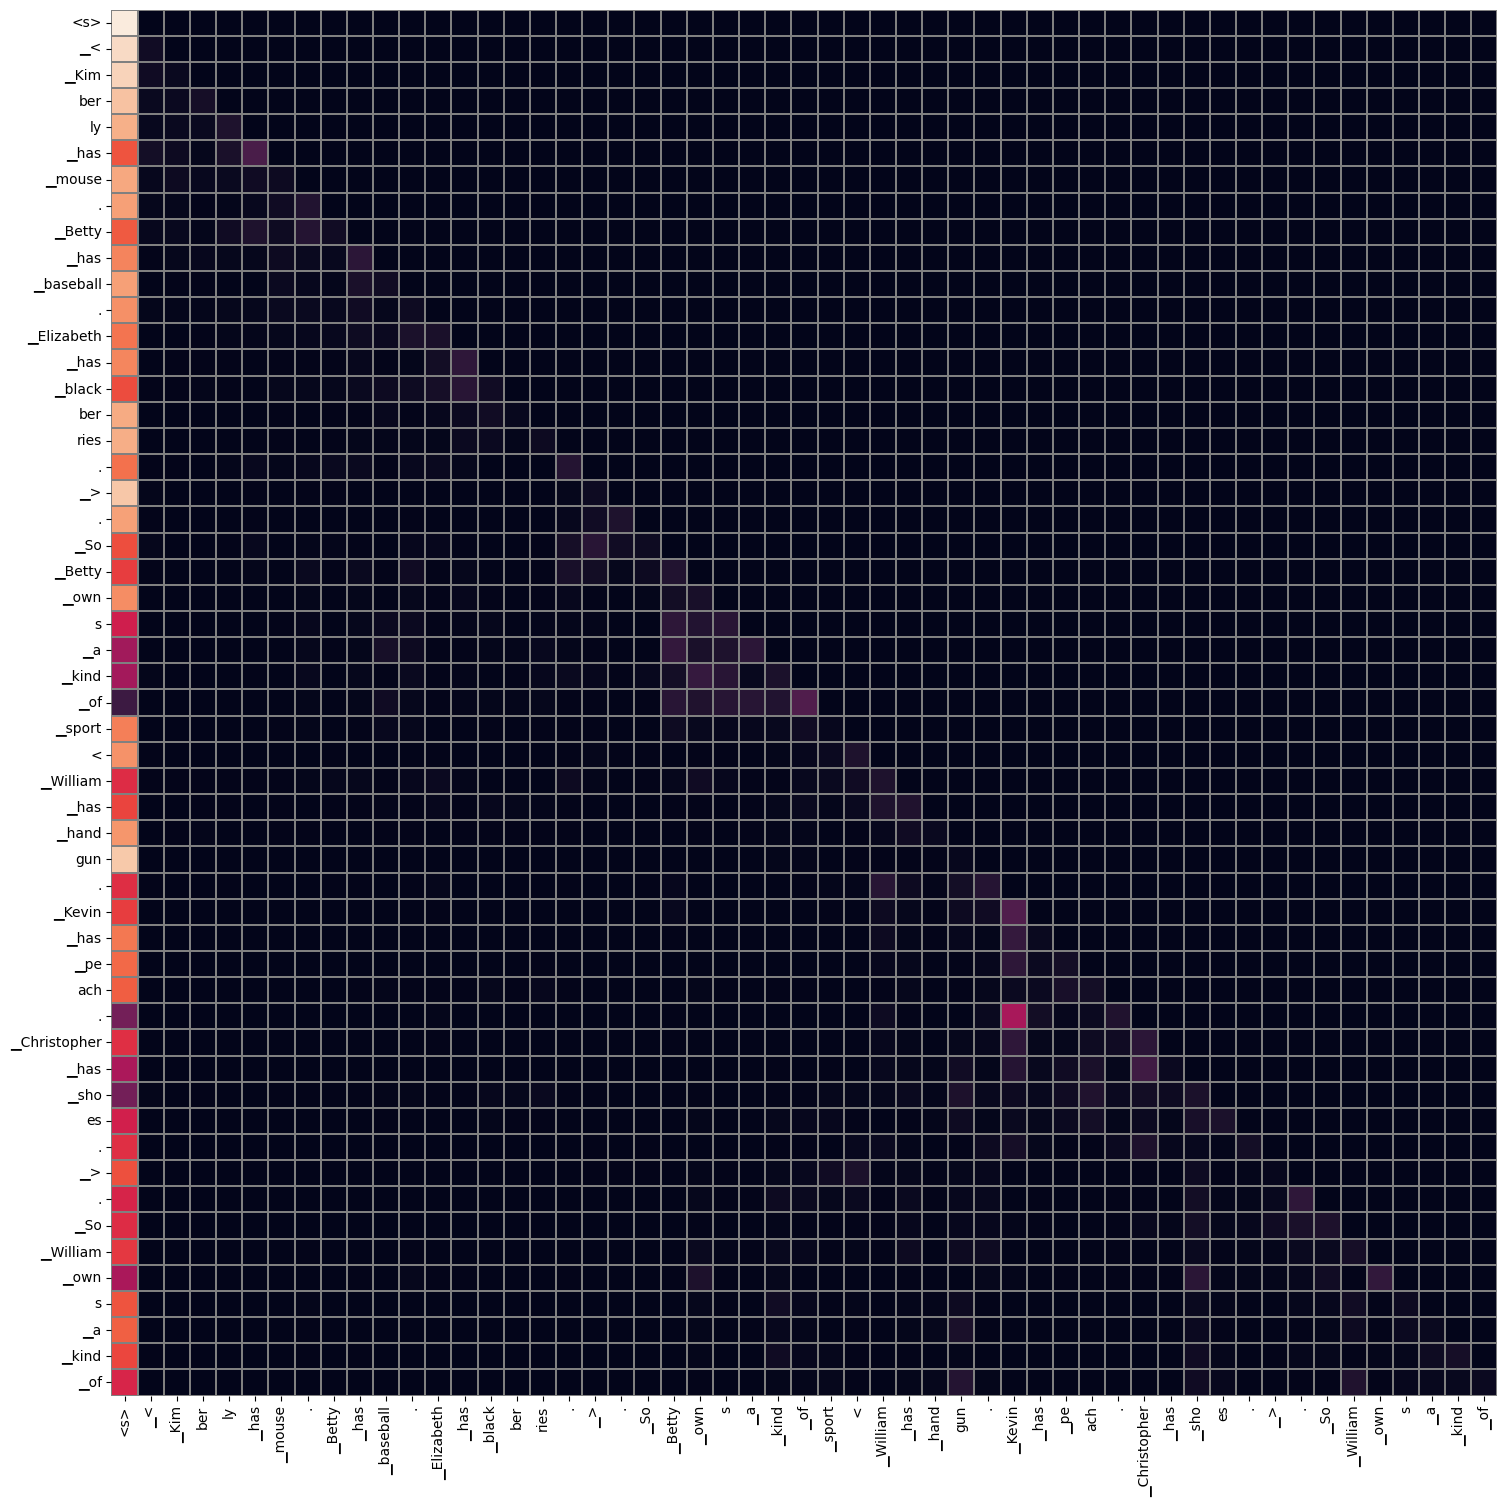

In [43]:
from eap.attribute import tokenize_plus
for clean, corrupt, label in dataloader[0:1]:
    # tokens_ids = model.to_tokens(clean, prepend_bos=True, padding_side='right')
    token_ids, attention_mask, input_lengths, n_pos = tokenize_plus(model, clean)
    clean_logits, cache = model.run_with_cache(token_ids, attention_mask = attention_mask)
    tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
    attn = cache[f'blocks.{layer}.attn.hook_pattern'][0][head]
    _plot_attn(attn, tokens, figsize=(18, 18))

Text(0.5, 0.88, 'g_task')

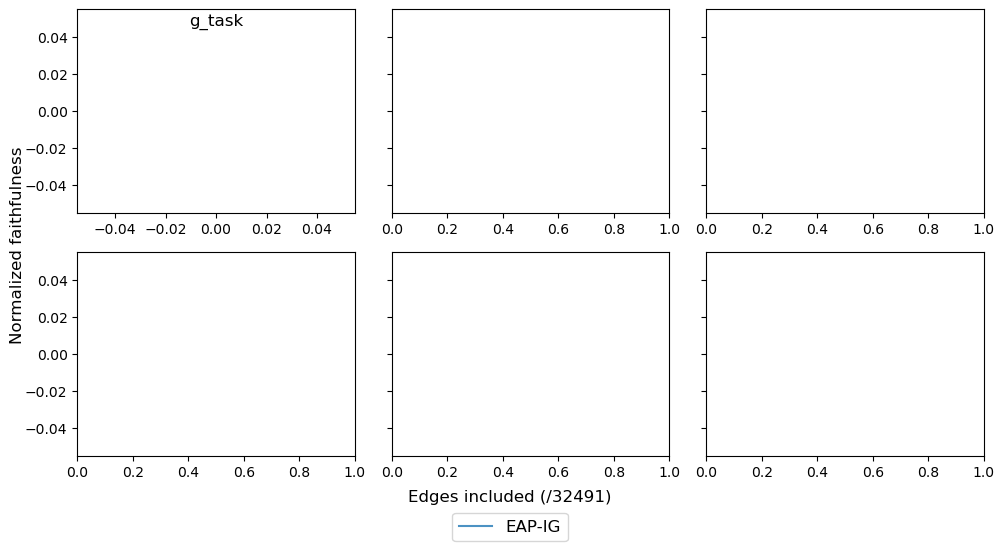

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
display_name_dict = {'g_task': 'g_task'}
def display_name(task):
    if '-comma' in task:
        task = task[:-6]
    return display_name_dict[task] 

prob_diff_tasks = ['greater-than', 'fact-retrieval', 'sva', 'g_task']
def task_to_metric(task):
    if any(ptask in task for ptask in prob_diff_tasks):
        return 'prob_diff'
    return 'logit_diff'

def metric_to_name(metric):
    if 'real' in metric:
        return 'activation-patching' + metric[4:]
    else:
        return metric

model = 'vicuna-33b-v1.3'
task_names = ['g_task']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,5), sharey=True)
for i, (task_name, ax) in enumerate(zip(task_names, axs.flat)):
    df = pd.read_csv(f'/home/hushengchun/project/eap-ig-faithfulness/results/pareto/{model}/csv/{task_name}.csv')
    for losstype in ['EAP-IG']:
        df[f'loss_{losstype}'] = (df[f'loss_{losstype}'] - df['corrupted_baseline']) /(df['baseline'] - df['corrupted_baseline'])
        ax.plot(df[f'edges_{losstype}'], df[f'loss_{losstype}'], label=losstype, alpha=0.8)
    
    ax.yaxis.set_tick_params(labelbottom=True)

    title_y = 0.88 #1.0 if i < 3 else 0.88
    ax.set_title(f'{display_name(task_name)}', y=title_y)

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=5, fontsize=12)
xlabel = fig.text(0.5, -0.015, f'Edges included (/32491)', ha='center', fontsize=12)
ylabel = fig.text(-0.00, 0.5, 'Normalized faithfulness', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()
fig.show()